In [40]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward (generic function with 1 method)

# Compressed sensing

Consider the 200-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. The forward model $G \in R^{20 \times 200}$ is a random Gaussian matrix


   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

## Naive approach $[y; \sqrt{|\theta|}]$

In [41]:

function aug_prediction(y, θ)
    return [y; sqrt.(abs.(θ))]
    # return [y; θ]
end

function aug_error(s_param::Setup_Param, θ::Array{FT, 1}, y, forward, aug_Σ_η) where {FT<:AbstractFloat}
    aug_θ = forward(s_param, θ)
    N_θ = length(θ)
    N_y = length(y)
    
    e1 = (aug_θ[1:N_y] - y)'*(aug_Σ_η[1:N_y,1:N_y]\(aug_θ[1:N_y] - y))
    e2 = aug_θ[N_y+1:N_y+N_θ]'*(aug_Σ_η[N_y+1:N_y+N_θ,N_y+1:N_y+N_θ]\aug_θ[N_y+1:N_y+N_θ])
    
    return e1, e2
end

function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return aug_prediction(G * θ, θ)
end

function Compressed_Sensing()
    
    # N_y, N_θ, N_nonzero = 20, 40, 10
    N_y, N_θ, N_nonzero = 20, 200, 10
    
    θ0_bar = zeros(Float64, N_θ)  # mean 
    
    Random.seed!(123);
    G = rand(Normal(1, 1), N_y, N_θ)
    
    θ_ref = zeros(Float64, N_θ)
    θ_ref[rand(1:N_θ, N_nonzero)] .= 1
    
    y = G*θ_ref
    Σ_η = Array(Diagonal(fill(0.01^2, size(y))))


    return θ_ref, G, y, Σ_η
end

Compressed_Sensing (generic function with 1 method)

## Unscented Kalman Inversion

When the unscented Kalman inversion is applied with $\theta_0 \sim \mathcal{N}(0, I)$

In [42]:
FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 50

    
θ_ref, G, y, Σ_η = Compressed_Sensing()
    
N_θ = length(θ_ref)
N_y = length(y)

# augmented system
s_param = Setup_Param(G, N_θ, N_y + N_θ)
θ0_mean = zeros(FT, N_θ)
# θ0_mean = uki_objs.θ_mean[end]
# θ0_mean = copy(θ_ref)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
λ_cov = Array(Diagonal(fill(0.01^2, N_θ)))
aug_y = aug_prediction(y, θ0_mean)  
aug_Σ_η = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  λ_cov]

    
uki_objs = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    aug_y, aug_Σ_η,
    α_reg,
    update_freq,
    N_iter);
    
    


┌ Info: ("optimization error at iter 1 = ", 9.76055752222302e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 14.142135623730951)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 63639.65489370435)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 26.83281572999796)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 319844.57791701314)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 44.61303077307392)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 1.4891112704247837e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblem

┌ Info: ("optimization error at iter 29 = ", 44125.83706877874)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 29 = ", 0.0003291956346794023)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 30 = ", 44018.140654737515)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 30 = ", 0.0003333051949057748)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 31 = ", 43928.2306819815)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 31 = ", 0.0003394143677285214)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 32 = ", 43911.77568107332)
└ @ Main /Users/huang/Desktop/Code/I

In [43]:
using GLMNet
path = glmnet(G, y)

Least Squares GLMNet Solution Path (83 solutions for 200 predictors in 585 passes):
──────────────────────────────
      df    pct_dev          λ
──────────────────────────────
 [1]   0  0.0        1.94703
 [2]   2  0.0394589  1.85853
 [3]   2  0.0808182  1.77406
 [4]   3  0.127837   1.69343
 [5]   5  0.178007   1.61646
 [6]   7  0.244678   1.54299
 [7]   7  0.307837   1.47286
 [8]   8  0.365612   1.40591
 [9]   8  0.418487   1.34201
[10]   8  0.466627   1.28101
[11]   8  0.510489   1.22279
[12]   8  0.550454   1.16721
[13]   8  0.586869   1.11416
[14]   7  0.620004   1.06352
[15]   7  0.649852   1.01518
[16]   7  0.677047   0.969041
[17]   7  0.701826   0.924996
[18]   8  0.725843   0.882954
[19]   8  0.748272   0.842822
[20]   8  0.768701   0.804515
[21]   8  0.787315   0.767948
[22]   8  0.804275   0.733044
[23]   9  0.819818   0.699726
[24]   9  0.834228   0.667922
[25]   9  0.847359   0.637564
[26]  10  0.85937    0.608586
[27]  10  0.870573   0.580925
[28]  10  0.880774   0.55452

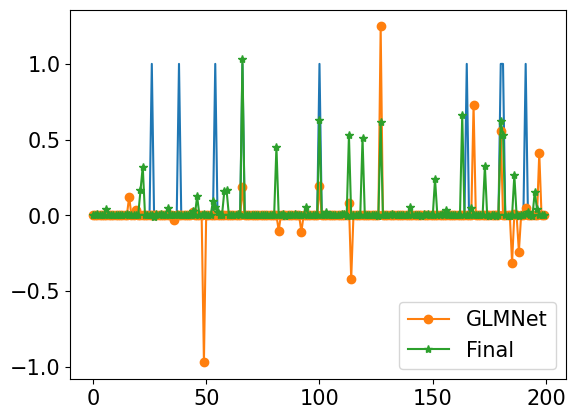

┌ Info: ("UKI error: ", 394.61613951915234, 85779.01398137622)
└ @ Main In[44]:7
┌ Info: ("GLMNet error: ", 1.2499682644030001e7, 58344.14366248971)
└ @ Main In[44]:9


In [44]:
plot(θ_ref)
plot(path.betas[:,end], "-o", label="GLMNet")
plot(uki_objs.θ_mean[end], "-*", label="Final")
legend()

e1, e2 = aug_error(s_param, uki_objs.θ_mean[end], y, forward, aug_Σ_η)
@info "UKI error: ", e1, e2
e1, e2 = aug_error(s_param, path.betas[:,end], y, forward, aug_Σ_η)
@info "GLMNet error: ", e1, e2

## Naive approach $[y; \sqrt{|\theta|}; \theta]$

In [27]:
function aug_prediction(y, θ)
    return [y; sqrt.(abs.(θ)); θ]
    # return [y; θ]
end

FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 50

    
θ_ref, G, y, Σ_η = Compressed_Sensing()
    
N_θ = length(θ_ref)
N_y = length(y)

# augmented system
s_param = Setup_Param(G, N_θ, N_y + N_θ + N_θ)
θ0_mean = zeros(FT, N_θ)

θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
λ_cov = Array(Diagonal(fill(0.01^2, N_θ)))
aug_y = aug_prediction(y, θ0_mean)  
aug_Σ_η = [Σ_η zeros(Float64, N_y, 2N_θ); 
           zeros(Float64, N_θ, N_y)  λ_cov zeros(Float64, N_θ, N_θ);
           zeros(Float64, N_θ, N_y+N_θ)  θθ0_cov]

    
uki_objs = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    aug_y, aug_Σ_η,
    α_reg,
    update_freq,
    N_iter);
    
    

┌ Info: ("optimization error at iter 1 = ", 1.0268583204116703e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 14.142135623730951)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 53325.214893313256)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 13.416407864999744)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 230341.40545330886)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 11.54767665626931)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 805546.1797907721)
└ @ Main /Users/huang/Desktop/Code/InverseProble

┌ Info: ("optimization error at iter 29 = ", 32832.656032908955)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 29 = ", 0.0002750365040089326)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 30 = ", 32698.1858682106)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 30 = ", 0.00026805713546055617)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 31 = ", 32759.58636321039)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 31 = ", 0.0002593174619324182)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 32 = ", 32495.192508172193)
└ @ Main /Users/huang/Desktop/Code

In [28]:
using GLMNet
path = glmnet(G, y)

Least Squares GLMNet Solution Path (83 solutions for 200 predictors in 585 passes):
──────────────────────────────
      df    pct_dev          λ
──────────────────────────────
 [1]   0  0.0        1.94703
 [2]   2  0.0394589  1.85853
 [3]   2  0.0808182  1.77406
 [4]   3  0.127837   1.69343
 [5]   5  0.178007   1.61646
 [6]   7  0.244678   1.54299
 [7]   7  0.307837   1.47286
 [8]   8  0.365612   1.40591
 [9]   8  0.418487   1.34201
[10]   8  0.466627   1.28101
[11]   8  0.510489   1.22279
[12]   8  0.550454   1.16721
[13]   8  0.586869   1.11416
[14]   7  0.620004   1.06352
[15]   7  0.649852   1.01518
[16]   7  0.677047   0.969041
[17]   7  0.701826   0.924996
[18]   8  0.725843   0.882954
[19]   8  0.748272   0.842822
[20]   8  0.768701   0.804515
[21]   8  0.787315   0.767948
[22]   8  0.804275   0.733044
[23]   9  0.819818   0.699726
[24]   9  0.834228   0.667922
[25]   9  0.847359   0.637564
[26]  10  0.85937    0.608586
[27]  10  0.870573   0.580925
[28]  10  0.880774   0.55452

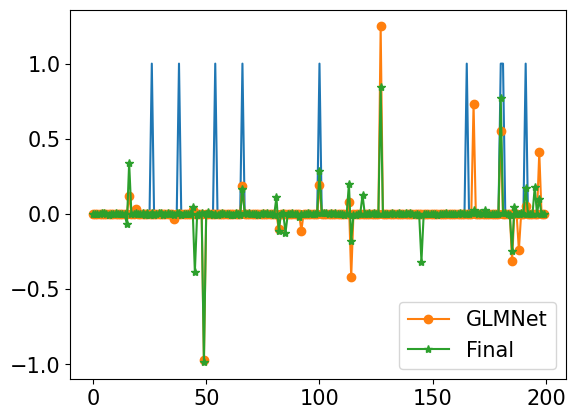

┌ Info: ("UKI error: ", 409.3751306759863, 64447.90990036705)
└ @ Main In[29]:7
┌ Info: ("GLMNet error: ", 27831.649282937844, 58344.14366248966)
└ @ Main In[29]:9


In [29]:
plot(θ_ref)
plot(path.betas[:,end], "-o", label="GLMNet")
plot(uki_objs.θ_mean[end], "-*", label="Final")
legend()

e1, e2 = aug_error(s_param, uki_objs.θ_mean[end], y, forward, aug_Σ_η)
@info "UKI error: ", e1, e2
e1, e2 = aug_error(s_param, path.betas[:,end], y, forward, aug_Σ_η)
@info "GLMNet error: ", e1, e2

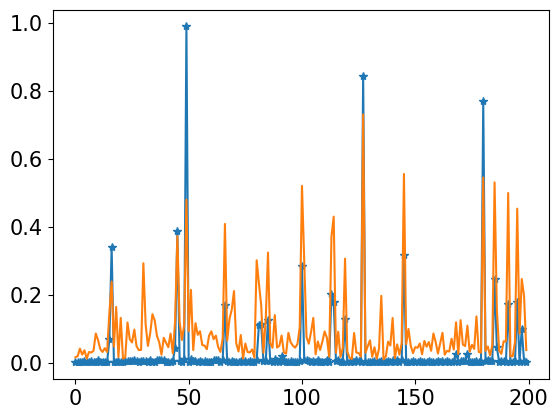

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccf28ca310>

In [30]:

plot(abs.(uki_objs.θ_mean[end]), "-*", label="Final")
plot(diag(uki_objs.θθ_cov[end])*1e4)

## LASSO $G(x) = \sqrt{|x|}$ 

In [31]:
function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    return  [abs.(θ).^0.5;]
end

FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 100

N_θ = 1
N_y = 1
y = zeros(FT, N_y)
G = zeros(FT, N_θ, N_y)
# augmented system
s_param = Setup_Param(G, N_θ, N_y)
θ0_mean = ones(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(0.1^2, N_θ)))
Σ_η = Array(Diagonal(fill(0.1^2, N_y)))



uki_objs = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    y, Σ_η,
    α_reg,
    update_freq,
    N_iter;
    modified_uscented_transform = true);
    

┌ Info: ("optimization error at iter 1 = ", 49.99999999999999)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 0.010000000000000002)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 29.974854938287052)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 0.01598486975837945)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 5.998725948592788)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 0.01903583520468275)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 4.616633528621041)
└ @ Main /Users/huang/Desktop/Code/InverseProbl

┌ Info: ("optimization error at iter 35 = ", 0.47201350462648484)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 35 = ", 3.4341684646175034e7)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 36 = ", 0.4717610808760272)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 36 = ", 6.868336929232773e7)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 37 = ", 0.47154906093716403)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 37 = ", 1.3736673858463317e8)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 38 = ", 0.47137094517988015)
└ @ Main /Users/huang/Desktop/Cod

┌ Info: ("optimization error at iter 69 = ", 0.4704365032307137)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 69 = ", 5.89985649779085e17)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 70 = ", 0.4704358109594539)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 70 = ", 1.17997129955817e18)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 71 = ", 0.47043522882211625)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 71 = ", 2.35994259911634e18)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 72 = ", 0.4704347393521067)
└ @ Main /Users/huang/Desktop/Code/In

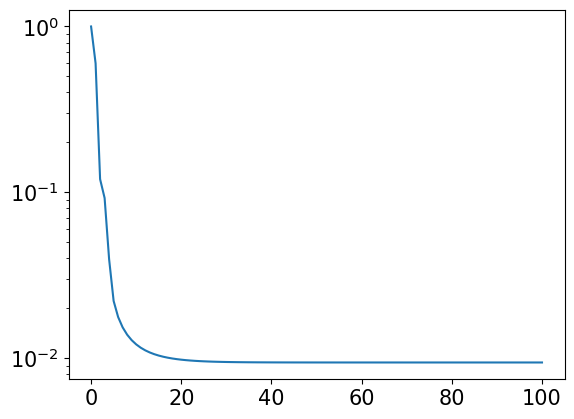

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccd11df100>

In [32]:
semilogy([abs.(uki_objs.θ_mean[i]) for i = 1:length(uki_objs.θ_mean)])

# Elastic Net $G(x) = [\sqrt{|x|} ; x]$ 

In [33]:
function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    return  [abs.(θ).^0.5; θ]
end

FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 100

N_θ = 1
N_y = 2
y = zeros(FT, N_y)
G = zeros(FT, N_θ, N_y)
# augmented system
s_param = Setup_Param(G, N_θ, N_y)
θ0_mean = ones(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(0.1^2, N_θ)))
Σ_η = Array(Diagonal(fill(0.1^2, N_y)))

Σ_η = [0.1^2  0 ; 0 10.0^2]


uki_objs = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    y, Σ_η,
    α_reg,
    update_freq,
    N_iter;
    modified_uscented_transform = true);    

┌ Info: ("optimization error at iter 1 = ", 50.004999999999995)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 0.010000000000000002)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 29.97425610563313)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 0.0159835922801751)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 5.99774804601675)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 0.019032490424804968)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 4.614675972581461)
└ @ Main /Users/huang/Desktop/Code/InverseProble

┌ Info: ("optimization error at iter 35 = ", 1.4364948614905856e-6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 35 = ", 99.99970892970825)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 36 = ", 7.182323108929093e-7)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 36 = ", 99.9998544646423)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 37 = ", 3.591107018582057e-7)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 37 = ", 99.99992723226819)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 38 = ", 1.7955339581794586e-7)
└ @ Main /Users/huang/Desktop/Code/

┌ Info: ("optimization error at iter 69 = ", 8.360882568338315e-17)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 69 = ", 100.0)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 70 = ", 4.1804412841691554e-17)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 70 = ", 99.99999999999999)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 71 = ", 2.0902206420845777e-17)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 71 = ", 100.0)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 72 = ", 1.0451103210422887e-17)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.

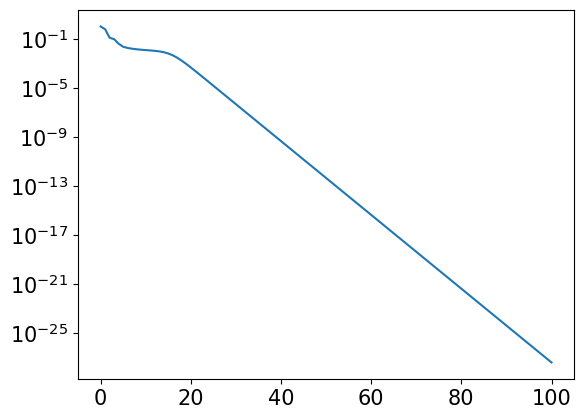

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccf1b7f6d0>

In [34]:
semilogy([abs.(uki_objs.θ_mean[i]) for i = 1:length(uki_objs.θ_mean)])

# Sparse Bayesian learning
$$\theta_i \sim N(0, \alpha_i^{-1}) \qquad \alpha_i \sim \textrm{Gamma}(\alpha_i| a, b)$$
here $\alpha^{-1}_i$ is the covariance and $a$, $b$ are very small

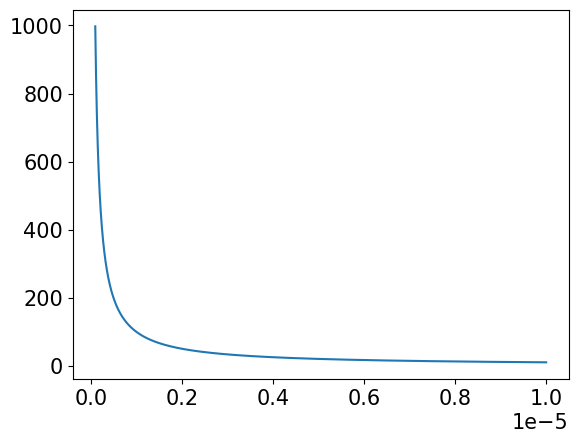

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccd10d8fd0>

In [35]:
using SpecialFunctions
function myGamma(x, a, b)
    
    return b^a/gamma(a)*(x.^(a - 1).*exp.(-b*x))

end

xx = Array(LinRange(1e-7, 1e-5, 10000))
p = myGamma(xx, 1e-4, 1e-4)
plot(xx, p)

In [36]:
function aug_prediction(y, ξ, α)
    return [y; ξ; α]
    # return [y; θ]
end

function forward(s_param::Setup_Param, aug_θ::Array{FT, 1}) where {FT<:AbstractFloat}
    # θ has covariance 1/α^2, θ = ξ/|α|, with ξ ∼ N(0,1)
    # θ = [ξ; α]
    N_θ   =  div(length(aug_θ), 2)
    ξ , α =  aug_θ[1:N_θ], aug_θ[N_θ+1:2N_θ]
    θ = ξ ./ (abs.(α) .+ 1e-6)
    
    G = s_param.G 
    
    return aug_prediction(G * θ, ξ, α)
end

function Compressed_Sensing()
    
    # N_y, N_θ, N_nonzero = 20, 40, 10
    N_y, N_θ, N_nonzero = 20, 200, 10
    
    θ0_bar = zeros(Float64, N_θ)  # mean 
    
    Random.seed!(123);
    G = rand(Normal(0, 1), N_y, N_θ)
    
    θ_ref = zeros(Float64, N_θ)
    θ_ref[rand(1:N_θ, N_nonzero)] .= 1
    
    y = G*θ_ref
    Σ_η = Array(Diagonal(fill(0.01^2, size(y))))


    return θ_ref, G, y, Σ_η
end

Compressed_Sensing (generic function with 1 method)

In [37]:
FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 50

    
θ_ref, G, y, Σ_η = Compressed_Sensing()
    
N_θ = length(θ_ref)
N_y = length(y)

# augmented system
s_param = Setup_Param(G, 2N_θ, N_y + 2N_θ)
θ0_mean = [zeros(FT, N_θ); ones(FT, N_θ)]

θθ0_cov = Array(Diagonal(fill(1.0^2, 2N_θ)))
ξ_cov = Array(Diagonal(fill(1^2, N_θ)))
α_cov = Array(Diagonal(fill(1.0^2, N_θ)))
aug_y = [y ; zeros(FT, 2N_θ)]

aug_Σ_η = [Σ_η zeros(Float64, N_y, 2N_θ); 
           zeros(Float64, N_θ, N_y)  ξ_cov zeros(Float64, N_θ, N_θ);
           zeros(Float64, N_θ, N_y+N_θ)  α_cov]
    
uki_objs = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    aug_y, aug_Σ_η,
    α_reg,
    update_freq,
    N_iter);

┌ Info: ("optimization error at iter 1 = ", 1.0269583204116703e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 20.0)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 1.0268761909920764e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 19.49358868961862)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 6.620596076217858e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 19.492794059107602)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 3.1402487899540467e6)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/

┌ Info: ("optimization error at iter 29 = ", 1.9371504424187158e12)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 29 = ", 18.987884329245308)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 30 = ", 3.8989333666758877e12)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 30 = ", 19.00926318050481)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 31 = ", 1.7022213248455981e12)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 31 = ", 19.014681233078537)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 32 = ", 5.531016503717808e11)
└ @ Main /Users/huang/Desktop/C

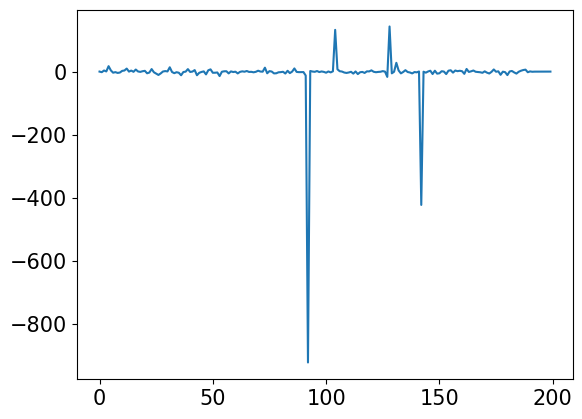

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcc955f8280>

In [38]:
plot(uki_objs.θ_mean[end][1:N_θ]./(uki_objs.θ_mean[end][N_θ+1:end] .+ 1e-3))

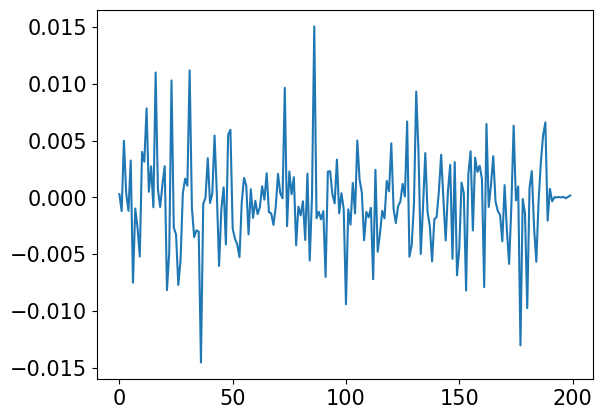

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcca6163d60>

In [39]:
plot(uki_objs.θ_mean[end][1:N_θ])